In [1]:
using LaTeXStrings
using GaussianProcesses
import GeoInterface
using Distributions
# using Base.LinAlg
using LibGEOS
using Distances
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [2]:
module GeoRDD
    using GaussianProcesses
    using PDMats
    include("src/geometry.jl")
    include("src/cliff_face.jl")
    include("src/point_estimates.jl")
    include("src/border_projection.jl")
end

GeoRDD

In this section, I want to do a quick simulation that shows the problem with the density-weighted estimator. Because the estimate ignores the covariance structure, it will give more weight to points along the boundary that are in wiggly sections, assuming all points are made equidistant.

To show this, I will create a boundary that is a triangular wave (zig-zag) between $x=0$ and $x=0.5$, and then just a straight line. The treatment effect isn't constant: it increases linearly from 0 at $x=0$ to 2 at $x=1$. That way, we will see that when the wiggly segment gains more influence, the estimate decreases. To distinguish the unweighted estimator from the density-weighted estimator, I also increase the density linearly with $x$. To avoid any confusion, I use the *true* density rather than an estimated density for the density-weighted estimator: the effect of the density estimation is irrelevant to the effect I wish to demonstrate.

# Setup

In [3]:
function border_line(numwiggles::Integer, A::Number)
    @assert numwiggles >= 0
    if numwiggles == 0
        line = [[0.0,0.0], [2.0,0.0]]
        return LineString(line)
    end
        
    x_left = collect(linspace(0, 0.5, numwiggles*4+1))
    y_left = repeat([0.0, A/2, 0.0, -A/2], outer=numwiggles)
    x = [x_left; 2.0]
    y = [y_left; 0.0; 0.0]
    @assert length(x) == length(y)
    
    line = [[xi, yi] for (xi,yi) in zip(x,y)]
    return LineString(line)
end

border_line (generic function with 1 method)

In [4]:
p=interpolate(border_line(5, 0.1), 0.3)

LibGEOS.Point(Ptr{Ptr{Void}} @0x00007f99665bbdd0)

In [5]:
GeoInterface.coordinates(p)

2-element Array{Float64,1}:
 0.134164 
 0.0316718

In [6]:
# define boundary:
# below 0.5: triangular wave
# above 0.5: straight line
bins = [0.0, 0.5, 1.5, 2.0]
densities = [1.0, 0.1, 2.8]
# τtrue     = [0.2, 1.0, 2.0]

function wb_density(x)
    if x < bins[2]
        return densities[1]
    elseif x < bins[3]
        return densities[2]
    else
        return densities[3]
    end
end

# define treatment effect 
function wb_τx(x)
    return x
end

wb_τx (generic function with 1 method)

In [7]:
wb_xx = linspace(0.0,2.0,1000)
mean([wb_τx(x) for x in wb_xx])

1.0

In this simulation setting, we can know the true value of the estimand. We will define the estimand as the density-weighted treatment effect when there are no wiggles. That way the grid of points along the boundary is evenly spaced, and the estimand is easily interpretable. We use $\rho(x)$ for the true population density at $x$.

$$ \tau = \frac{\int_0^1 \left. \tau(x) \rho(x) dx \right.}{\int_0^1 \left. \rho(x) dx \right.}$$

In [8]:
wb_xx = linspace(0.0,2.0,1000)
sum([wb_τx(x)*wb_density(x) for x in wb_xx])/sum([wb_density(x) for x in wb_xx])

1.3378378378378386

# Simulate

In [30]:
wb_A = 0.1
pw = diff(bins).*densities
X1distr = MixtureModel(
    [Uniform(bins[i],bins[i+1]) for i in 1:length(densities)],
    Categorical(pw ./ sum(pw))
    )
X2distr_treat = Uniform(wb_A/2, 1.0)
X2distr_ctrol = Uniform(-1.0, -wb_A/2)

Distributions.Uniform{Float64}(a=-1.0, b=-0.05)

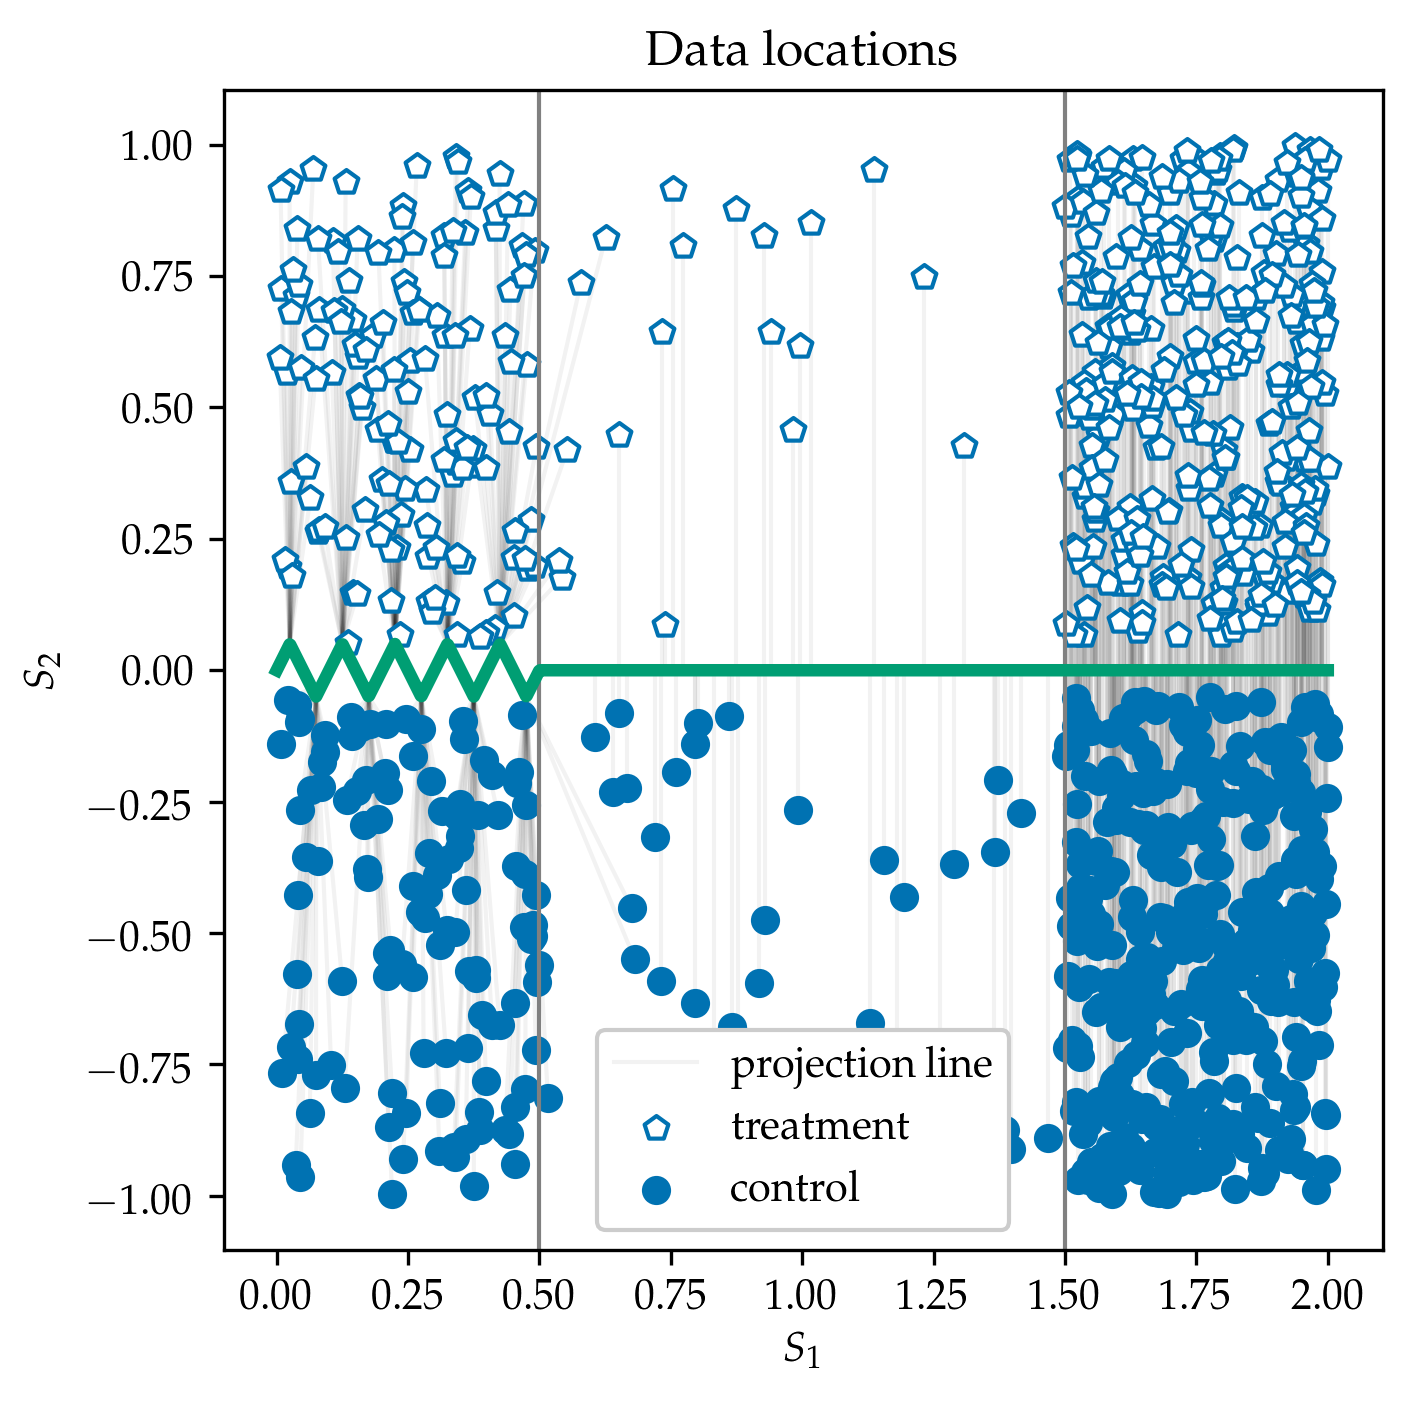

In [31]:
wb_nwiggles = 5
wb_n = 1000
wb_ntreat = 500
wb_nctrol = wb_n-wb_ntreat
wbX_treat = [rand(X1distr, wb_ntreat)'; 
             rand(X2distr_treat, wb_ntreat)']
wbX_ctrol = [rand(X1distr, wb_nctrol)'; 
             rand(X2distr_ctrol, wb_nctrol)']

wb_border = border_line(wb_nwiggles, wb_A)
border_points = [interpolate(wb_border,q) for q in linspace(0,geomLength(wb_border),1000)]
border_coords = [GeoInterface.coordinates(p) for p in border_points]
border_x = [p[1] for p in border_coords]
border_y = [p[2] for p in border_coords]


function plot_setup()
    plt.axvline(0.5, color="grey", linewidth=1)
    plt.axvline(1.5, color="grey", linewidth=1)
    for itreat in 1:wb_ntreat
        # obtain coordinates for treatment point
        x,y = wbX_treat[:,itreat]
        # projection onto border (as distance along border)
        proj_point = nearestPoints(wb_border, Point(x,y))[1]
#         proj_dist = project(wb_border, Point(x,y))
        # get border point from distance
#         proj_point = interpolate(wb_border, proj_dist)
        # get coordinates from point
        proj_x, proj_y = GeoInterface.coordinates(proj_point)
        if itreat==1
            label="projection line"
        else
            label=""
        end
        plt.plot([x, proj_x], [y, proj_y], 
                color="black", alpha=0.05, linewidth=1,
                label=label,
                zorder=-10)
    end
    for ictrol in 1:wb_nctrol
        # obtain coordinates for treatment point
        x,y = wbX_ctrol[:,ictrol]
        # projection onto border (as distance along border)
#         proj_dist = project(wb_border, Point(x,y))
        proj_point = nearestPoints(wb_border, Point(x,y))[1]
        # get border point from distance
#         proj_point = interpolate(wb_border, proj_dist)
        # get coordinates from point
        proj_x, proj_y = GeoInterface.coordinates(proj_point)
        plt.plot([x, proj_x], [y, proj_y], 
                color="black", alpha=0.05, linewidth=1,
                zorder=-10)
    end
    
    plt.scatter(wbX_treat[1,:],wbX_treat[2,:], color="white", edgecolor="#0072B2", marker="p", label="treatment")
    plt.scatter(wbX_ctrol[1,:],wbX_ctrol[2,:], color="#0072B2", label="control")
    ax = plt.gca()
    ax[:set_aspect]("equal")
    plt.plot(border_x, border_y, linewidth=3, color="#009E73")
    plt.grid(false)
    plt.title("Data locations")
    plt.legend(loc="best", framealpha=1.0)
    plt.xlabel(L"$S_1$")
    plt.ylabel(L"$S_2$")
end
plot_setup()
;

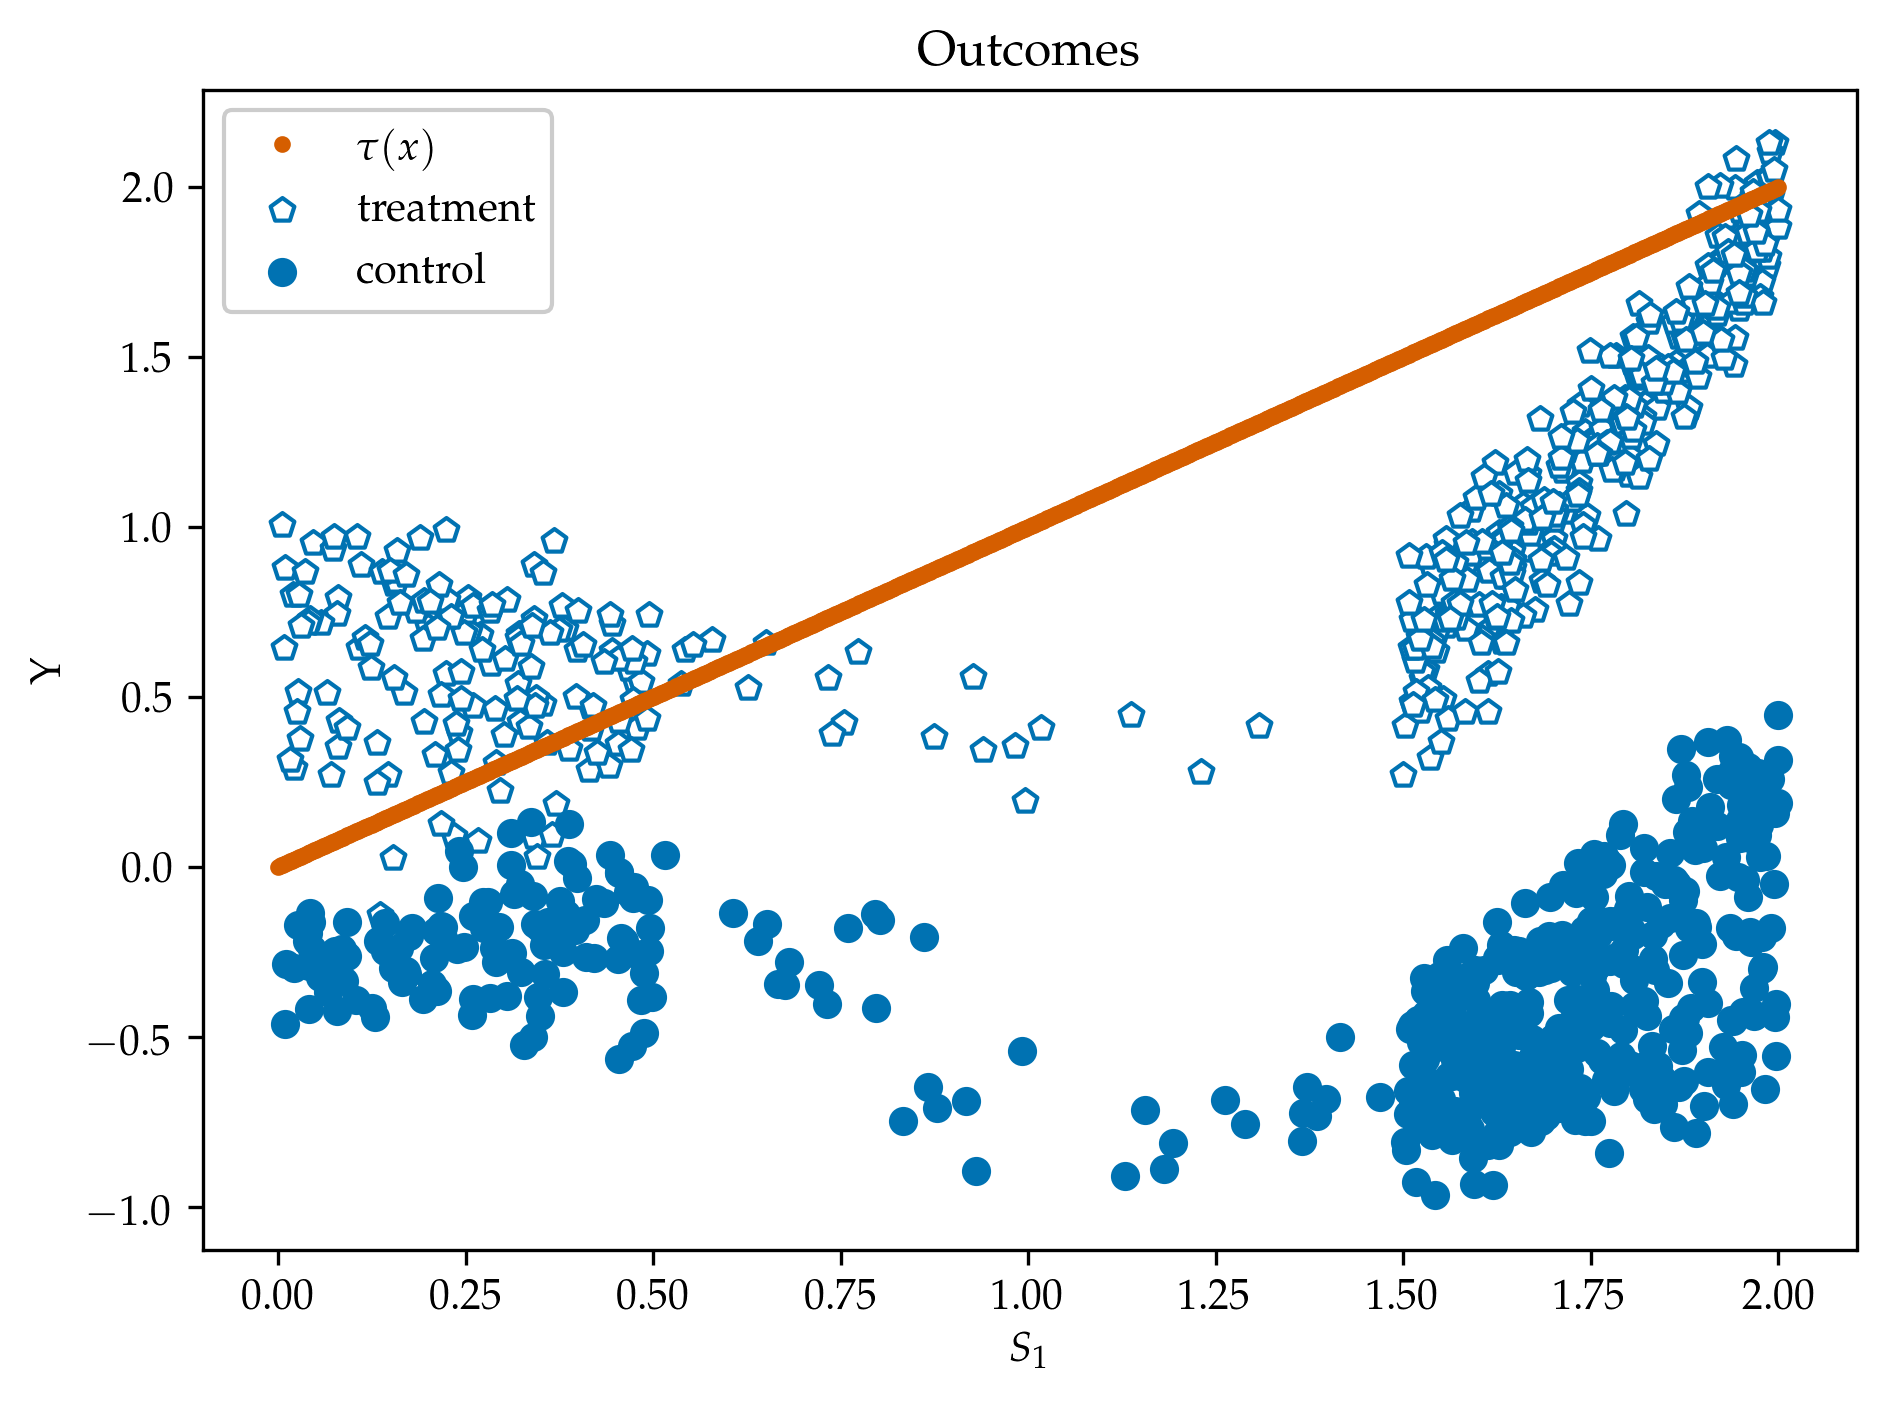

In [32]:
wb_kern = SE(log(0.4), log(0.5))
wb_Σprior=GaussianProcesses.cov(wb_kern, [wbX_treat wbX_ctrol])
wb_μprior=zeros(wb_n)
wb_Σobs=copy(wb_Σprior)
wb_σy2 = 0.1^2
for i in 1:wb_n
    wb_Σobs[i,i] += wb_σy2
end
wb_prior=MultivariateNormal(wb_μprior,wb_Σobs)
wb_Y=rand(wb_prior)
wb_treat = [ones(Bool,wb_ntreat);zeros(Bool,wb_nctrol)]
wb_Y[wb_treat] .+= [wb_τx(wbX_treat[1,i]) for i in 1:wb_ntreat] # apply treatment effect
function plot_outcomes()
    plt.scatter(vec(wbX_treat[1,:]), wb_Y[wb_treat], 
                color="white", 
                edgecolor="#0072B2", 
                marker="p", 
                label="treatment")
    plt.scatter(vec(wbX_ctrol[1,:]), wb_Y[.!wb_treat], 
                color="#0072B2", 
                label="control")
    plt.xlabel(L"S_1")
    plt.ylabel("Y")
    xx = linspace(0,2.0,1000)
    plt.plot(xx, wb_τx.(xx), ".", color="#D55E00", label=L"\tau(x)")
    plt.legend(loc="best", framealpha=1.0)
    plt.title("Outcomes")
end
plot_outcomes()
;

A quick histogram to check that the density is what we say it is:

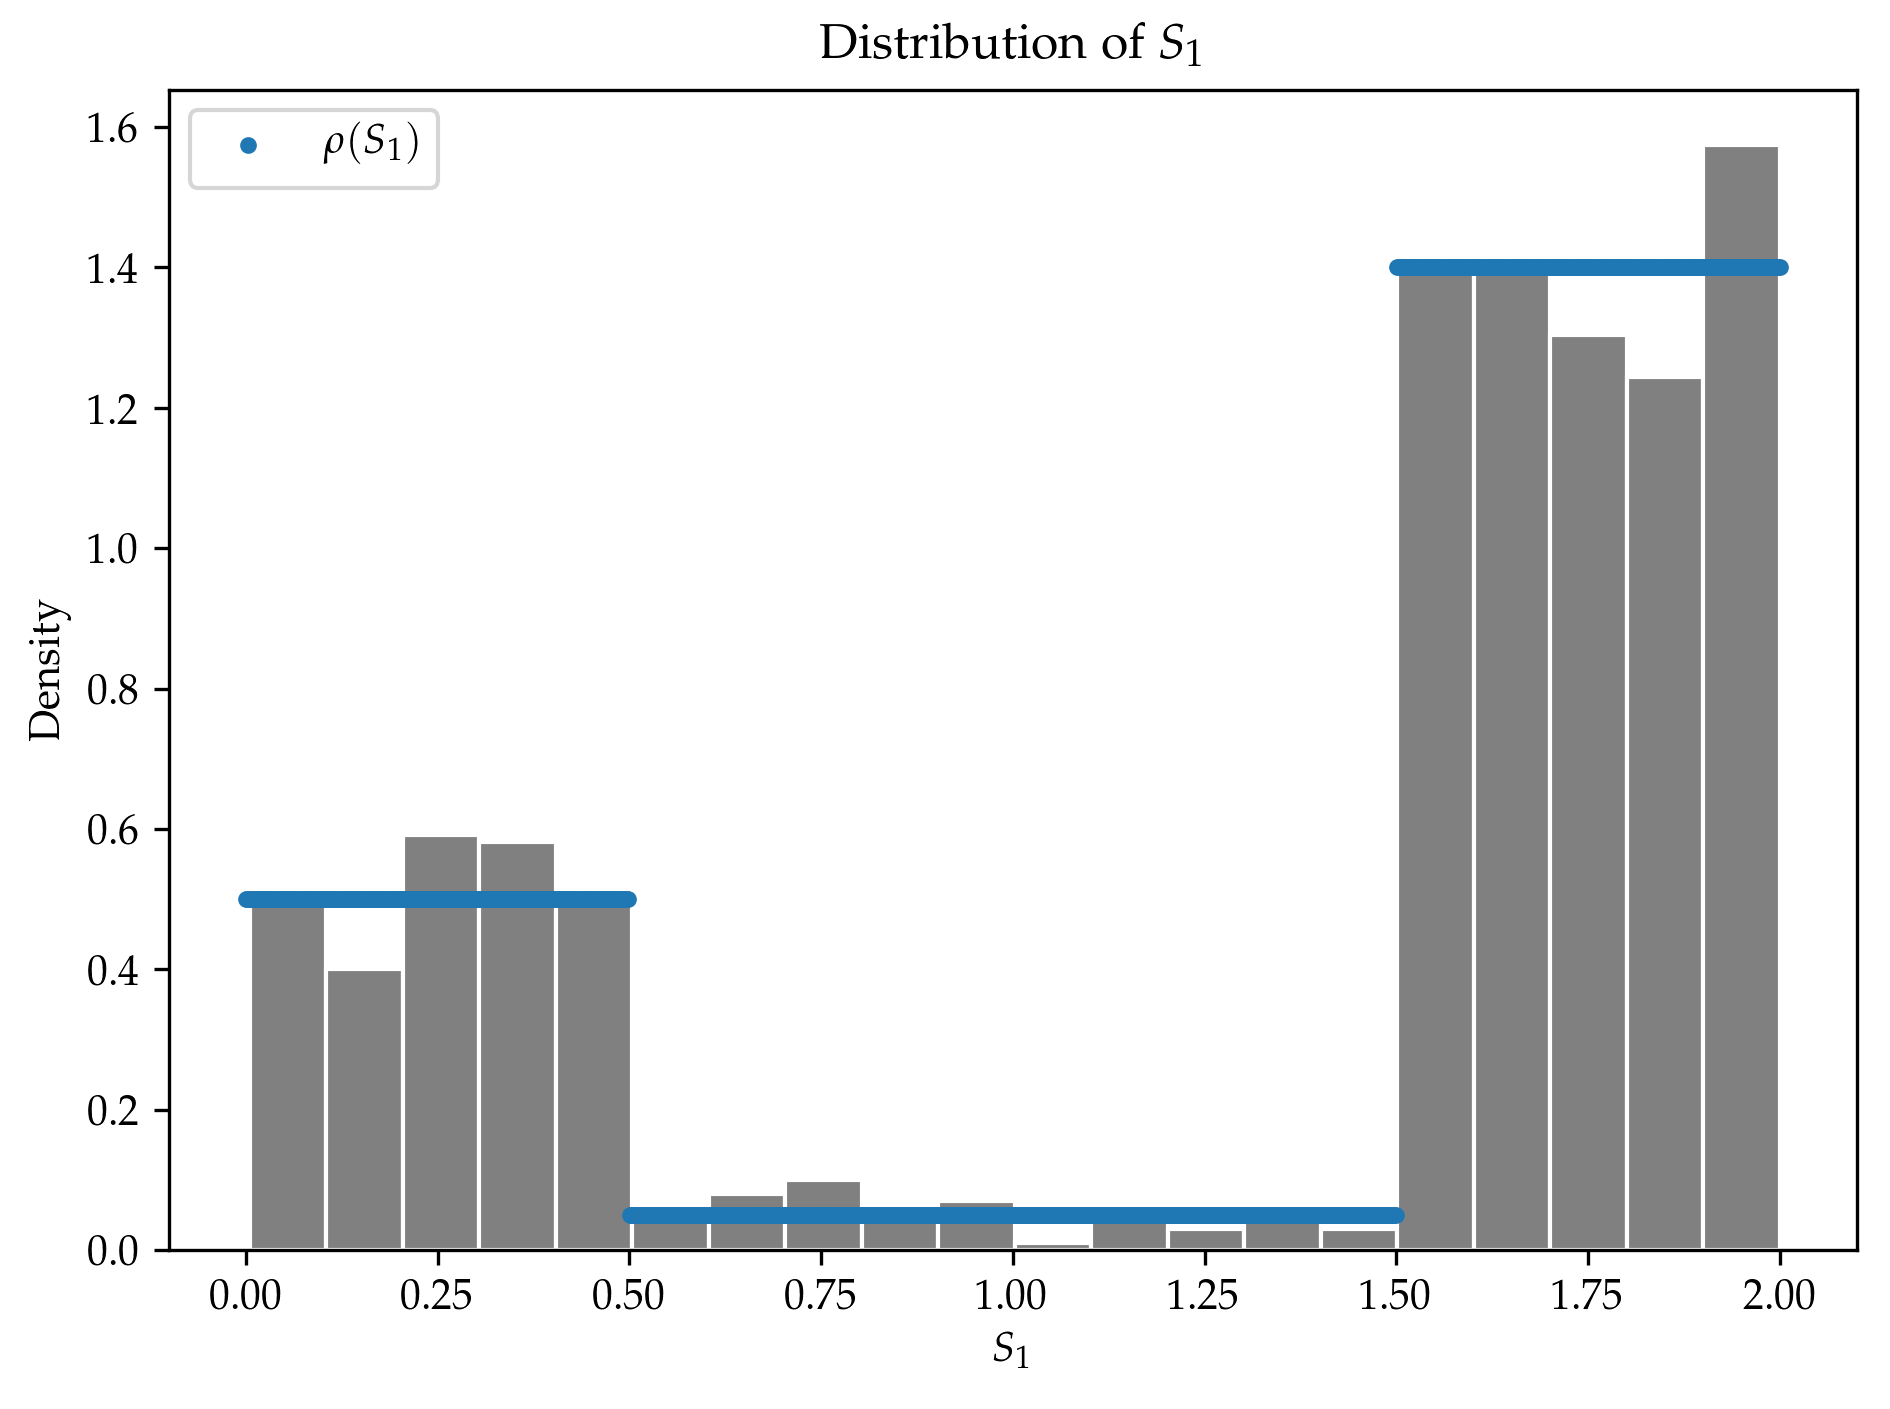

PyObject <matplotlib.legend.Legend object at 0x14fe93128>

In [33]:
function plot_x1()
    plt.title(L"Distribution of $S_1$")
    plt.plt[:hist](vec([wbX_treat wbX_ctrol][1,:]), 
                   color="grey", 
                   edgecolor="white",
                   bins=20, 
                   normed=true)
    xx=linspace(0,2.0,1000)
    plt.plot(xx,wb_density.(xx) ./ 2, ".", label=L"$\rho(S_1)$")
    plt.xlabel(L"$S_1$")
    plt.ylabel("Density")
    plt.legend(loc="best")
end
plot_x1()

Now, what are the actual simulations? I'm not actually going to touch the locations or the outcomes. The only change I am going to make is to the boundary. I am going to progressively increase the wiggliness of the left side of the boundary. The boundary grid points are always going to be equidistant, with $\Delta x = 0.01$ between points. That means that as the wiggliness increases, so does the number of boundary grid points.

The function `wb_estimators` below obtains the boundary grid points, generates GP predictions at those points from the treatment and control fitted GPs that were pre-computed, computes the posterior mean and variance of the difference at the boundary points, and then applies the three estimators of interest:

1. unweighted
2. inverse-variance weighted
3. density-weighted

We then show the estimate and credible intervals as a function of the number of wiggles between $x=0$ and $x=0.5$.

In [34]:
# function projection_points(gp::GPE, border::LineString)
#     X∂ = Array{Float64}(2, gp.nobsv)
#     for i in 1:gp.nobsv
#         # obtain coordinates for treatment point
#         x,y = gp.X[:,i]
#         # projection onto border (as distance along border)
#         proj_dist = project(border, Point(x,y))
#         # get border point from distance
#         proj_point = interpolate(border, proj_dist)
#         # get coordinates from point
#         proj_x, proj_y = GeoInterface.coordinates(proj_point)
#         X∂[1,i] = proj_x
#         X∂[2,i] = proj_y
#     end
#     return X∂
# end
# function proj_estimator(gpT::GPE, gpC::GPE, border::LineString)
#     X∂_treat = projection_points(gpT, border)
#     X∂_ctrol = projection_points(gpC, border)
#     X∂ = [X∂_treat X∂_ctrol]
    
#     μpost, Σpost = GeoRDD.cliff_face(gpT, gpC, X∂)
#     return GeoRDD.unweighted_mean(μpost, Σpost)
# end

# Geography-based infinite-population estimand

In [35]:
wb_fit_treat = GP(wbX_treat, wb_Y[wb_treat],  
                  MeanConst(mean(wb_Y[wb_treat])), 
                  wb_kern, log(√wb_σy2))
wb_fit_ctrol = GP(wbX_ctrol, wb_Y[.!wb_treat], 
                  MeanConst(mean(wb_Y[.!wb_treat])), 
                  wb_kern, log(√wb_σy2))

GP Exact object:
  Dim = 2
  Number of observations = 500
  Mean function:
    Type: GaussianProcesses.MeanConst, Params: [-0.343066]
  Kernel:
    Type: GaussianProcesses.SEIso, Params: [-0.916291, -0.693147]
  Input observations = 
[1.91096 1.89086 … 1.94887 0.19286; -0.127797 -0.564489 … -0.449486 -0.282587]
  Output observations = [0.13057, -0.165444, -0.167869, -0.0878634, -0.571639, -0.0261887, -0.222067, -0.700976, -0.489059, -0.934365  …  -0.396717, -0.696801, -0.031032, -0.398843, -0.208186, -0.387279, -0.161143, -0.179573, 0.085795, -0.389579]
  Variance of observation noise = 0.010000000000000005
  Marginal Log-Likelihood = 403.996

In [36]:
import IterTools
import DataStructures

In [37]:
module GeoRDD
    using GaussianProcesses
    using PDMats
    include("src/geometry.jl")
    include("src/cliff_face.jl")
    include("src/point_estimates.jl")
    include("src/border_projection.jl")
end

GeoRDD

# Estimators

In [55]:
function sentinels(border::LineString, nsent::Int)
    sentinel_distances = linspace(0,geomLength(border), nsent)
    sentinel_points = [interpolate(border,q) for q in sentinel_distances]
    sentinel_coords = [GeoInterface.coordinates(p) for p in sentinel_points]
    sentinels_x = [p[1] for p in sentinel_coords]
    sentinels_y = [p[2] for p in sentinel_coords]
    X∂ = [sentinels_x' ; sentinels_y']
    return X∂
end
function wb_estimators(gpT::GPE, gpC::GPE, nwiggles::Int)
    border = border_line(nwiggles, wb_A)
    n∂ = 1000
    X∂ = sentinels(border, n∂)
    
    density = (s1, s2) -> wb_density(s1)

    μpost, Σpost = GeoRDD.cliff_face(gpT, gpC, X∂)
    
    unweighted = GeoRDD.unweighted_mean(μpost, Σpost)
    
    invvariance = GeoRDD.inverse_variance(μpost, Σpost)
    
    stnl_ρ = wb_density.(X∂[1,:])
    densityw = GeoRDD.weighted_mean(μpost, Σpost, stnl_ρ)
    
    projτ = GeoRDD.proj_estimator(gpT, gpC, border)
    
    region_C = LibGEOS.Polygon([
        [[0.0, -1.0],    # bottom left
         [0.0, -wb_A/2], # top left
         [2.0, -wb_A/2], # top right
         [2.0, -1.0],    # bottom right
         [0.0, -1.0]]])
    region_T = LibGEOS.Polygon([
        [[0.0, 1.0],     # top left
         [0.0, wb_A/2],  # bottom left
         [2.0, wb_A/2],  # bottom right
         [2.0, 1.0],     # top right
         [0.0, 1.0]]])
    region = LibGEOS.union(region_C, region_T)
    
    maxdist = 0.2
    gridspace = 2.0/n∂
    inf_proj_τ = GeoRDD.infinite_proj_estim(gpT, gpC, border, region, 
                                                   maxdist, gridspace)
    
    infρ_proj_τ = GeoRDD.infinite_proj_estim(gpT, gpC, border, region, 
                                                    maxdist, gridspace; density=density)
    
    return (unweighted, invvariance, densityw, projτ, inf_proj_τ, infρ_proj_τ)
end

wb_estimators (generic function with 1 method)

In [56]:
function wb_estimands(gpT::GPE, gpC::GPE, nwiggles::Int)
    border = border_line(nwiggles, wb_A)
    n∂ = 1000
    X∂ = sentinels(border, n∂)
    
    _, Σpost = GeoRDD.cliff_face(gpT, gpC, X∂)
    
    density = (s1, s2) -> wb_density(s1)
    true_τ = Vector{Float64}(n∂)
    for i in 1:n∂
        s1, s2 = X∂[:,i]
        true_τ[i] = wb_τx(s1)
    end
    
    unweighted = GeoRDD.unweighted_mean(true_τ, Σpost)
    
    invvariance = GeoRDD.inverse_variance(true_τ, Σpost)
    
    stnl_ρ = wb_density.(X∂[1,:])
    densityw = GeoRDD.weighted_mean(true_τ, Σpost, stnl_ρ)
    
    # proj_estimator
    X∂_treat = GeoRDD.projection_points(gpT, border)
    X∂_ctrol = GeoRDD.projection_points(gpC, border)
    X∂_projected = [X∂_treat X∂_ctrol]
    n_proj = size(X∂_projected, 2)
    true_τ_proj = Vector{Float64}(n_proj)
    for i in 1:n_proj
        s1, s2 = X∂_projected[:,i]
        true_τ_proj[i] = wb_τx(s1)
    end
    
    _, Σpost = GeoRDD.cliff_face(gpT, gpC, X∂_projected)
    projτ = GeoRDD.unweighted_mean(true_τ_proj, Σpost)
    
    region_C = LibGEOS.Polygon([
        [[0.0, -1.0],    # bottom left
         [0.0, -wb_A/2], # top left
         [2.0, -wb_A/2], # top right
         [2.0, -1.0],    # bottom right
         [0.0, -1.0]]])
    region_T = LibGEOS.Polygon([
        [[0.0, 1.0],     # top left
         [0.0, wb_A/2],  # bottom left
         [2.0, wb_A/2],  # bottom right
         [2.0, 1.0],     # top right
         [0.0, 1.0]]])
    region = LibGEOS.union(region_C, region_T)
    
    # Infinite-population projection estimators
    X∂_projected, weights = GeoRDD.infinite_proj_sentinels(
            gpT, gpC, border, region, 0.2, 2.0/n∂)
    n_proj = size(X∂_projected, 2)
    true_τ_proj = Vector{Float64}(n_proj)
    for i in 1:n_proj
        s1, s2 = X∂_projected[:,i]
        true_τ_proj[i] = wb_τx(s1)
    end
    _, Σpost = GeoRDD.cliff_face(gpT, gpC, X∂_projected)
    inf_proj_τ = GeoRDD.weighted_mean(true_τ_proj, Σpost, weights)
    
    X∂_projected, weights = GeoRDD.infinite_proj_sentinels(
            gpT, gpC, border, region, 0.2, 2.0/n∂; density=density)
    infρ_proj_τ = GeoRDD.weighted_mean(true_τ_proj, Σpost, weights)
    return (unweighted, invvariance, densityw, projτ, inf_proj_τ, infρ_proj_τ)
end

wb_estimands (generic function with 1 method)

In [40]:
# wb_estimators(wb_fit_treat, wb_fit_ctrol, 3);
@time wb_estimators(wb_fit_treat, wb_fit_ctrol, 3);

  3.202238 seconds (2.20 M allocations: 332.758 MiB, 9.93% gc time)


In [57]:
# compute estimates
wb_nwiggles_arr = Int64[0; floor.(logspace(0,3,16))]
wb_estimators(wb_fit_treat, wb_fit_ctrol, 3);
@time wb_estimates = [wb_estimators(wb_fit_treat, wb_fit_ctrol, n) for n in wb_nwiggles_arr]
;

1231.089059 seconds (774.78 M allocations: 90.792 GiB, 2.60% gc time)


In [58]:
@time estimands = [wb_estimands(wb_fit_treat, wb_fit_ctrol, n) for n in wb_nwiggles_arr]
;

1156.669818 seconds (774.93 M allocations: 65.467 GiB, 2.37% gc time)


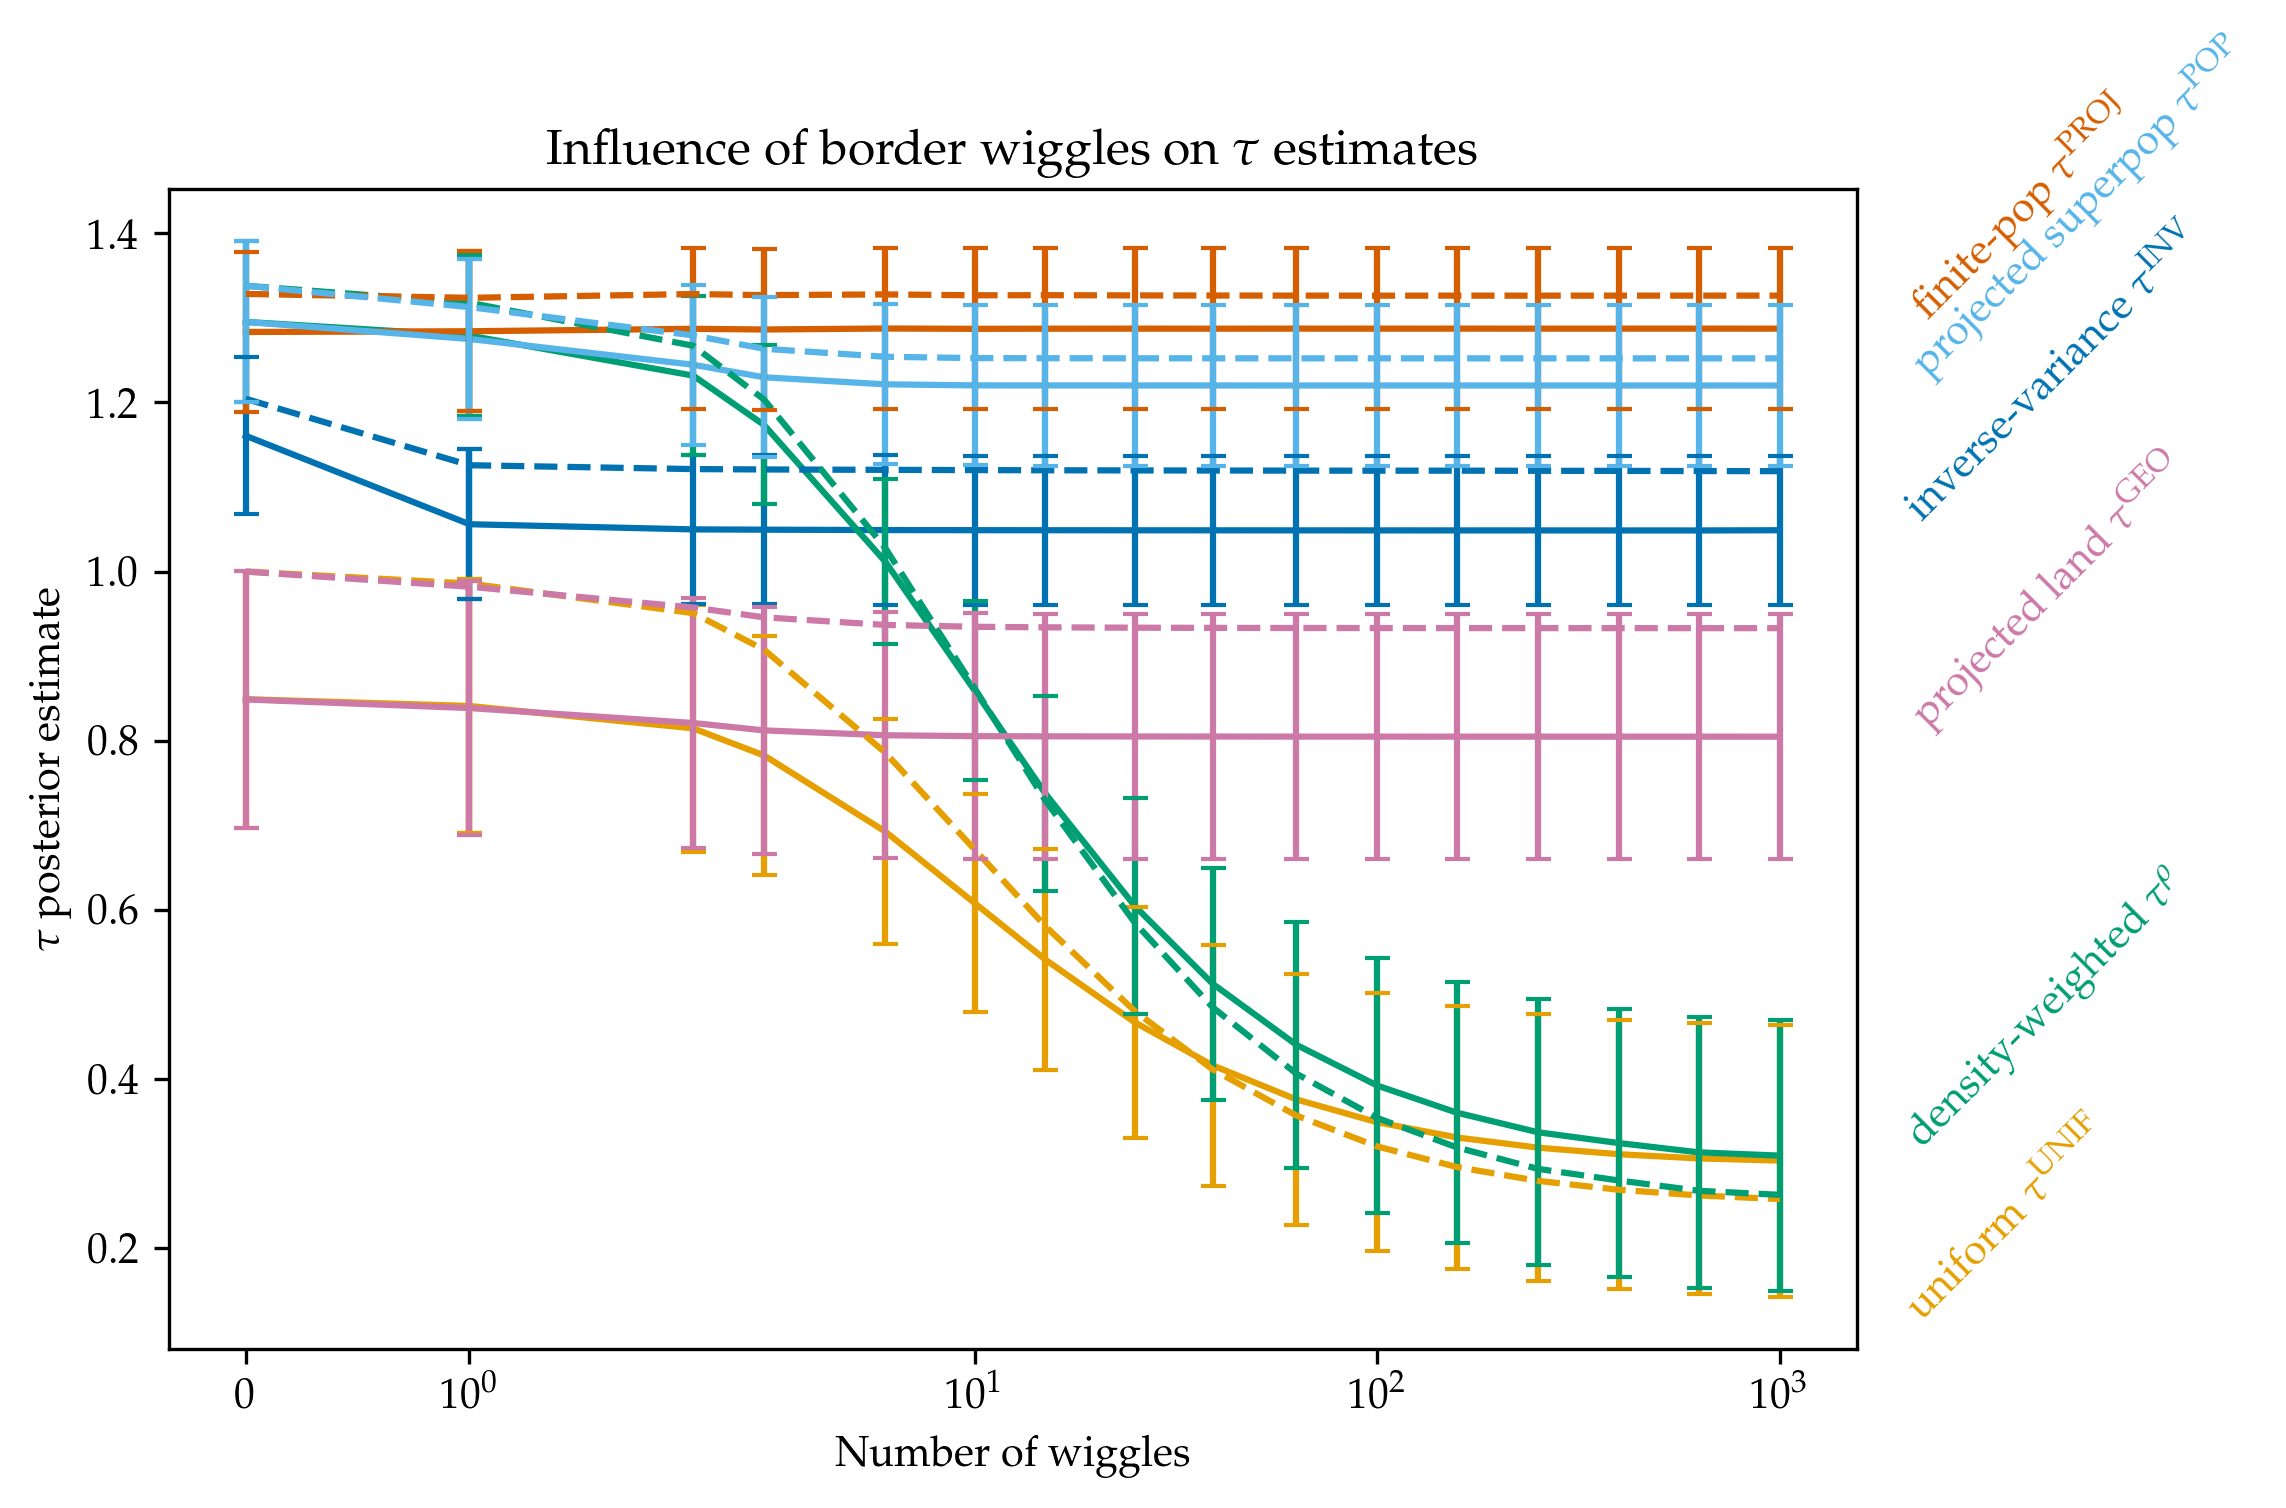

In [59]:
function plot_estimates()
    plt.title(L"Influence of border wiggles on $\tau$ estimates")
    capsize=3
    cbbPalette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", 
                  "#0072B2", "#D55E00", "#CC79A7"]
#     plt.axhline(wb_τrho_true, label=L"true $\tau^{\rho}$ w/o wiggles", 
#                 color=cbbPalette[4], linestyle="--")
#     plt.axhline(wb_τunif_true, label=L"true $\tau^{\mathrm{UNIF}}$ w/o wiggles", 
#                 color=cbbPalette[2], linestyle=":")
#     plt.axhline(τtrue[1], label=L"true $\tau:~S_1<0.5$", 
#                 color="grey", linestyle=":")
    for (iest, label, color) in zip(
            1:6,
             [L"uniform $\tau^{\mathrm{UNIF}}$",
              L"inverse-variance $\tau^{\mathrm{INV}}$",
              L"density-weighted $\tau^{\rho}$",
              L"finite-pop $\tau^{\mathrm{PROJ}}$",
              L"projected land $\tau^{\mathrm{GEO}}$",
              L"projected superpop $\tau^{\mathrm{POP}}$",
              ],
             cbbPalette[[2,6,4,7,8,3]]
             )
        y = [mean(wbe[iest]) for wbe in wb_estimates]
        plt.errorbar(wb_nwiggles_arr, 
            y, 
            yerr=[2*std(wbe[iest]) for wbe in wb_estimates], 
            capsize=capsize,
            barsabove=true,
            color=color,
            label=label)
        plt.plot(wb_nwiggles_arr, 
            [mean(wbe[iest]) for wbe in estimands], 
            color=color,
            linestyle="--")
        y_label = y[end]
        if iest == 1
            y_label -= 0.2
        end
        plt.text(x=2e3, y=y_label, s=label,
                 color=color,
                 rotation=45,
                 verticalalignment="bottom"
                 )
    end
    plt.xlabel("Number of wiggles")
    plt.ylabel(L"$\tau$ posterior estimate")
    plt.gca()[:set_xscale]("symlog")
end
plt.plt[:interactive](false)
plot_estimates()
;

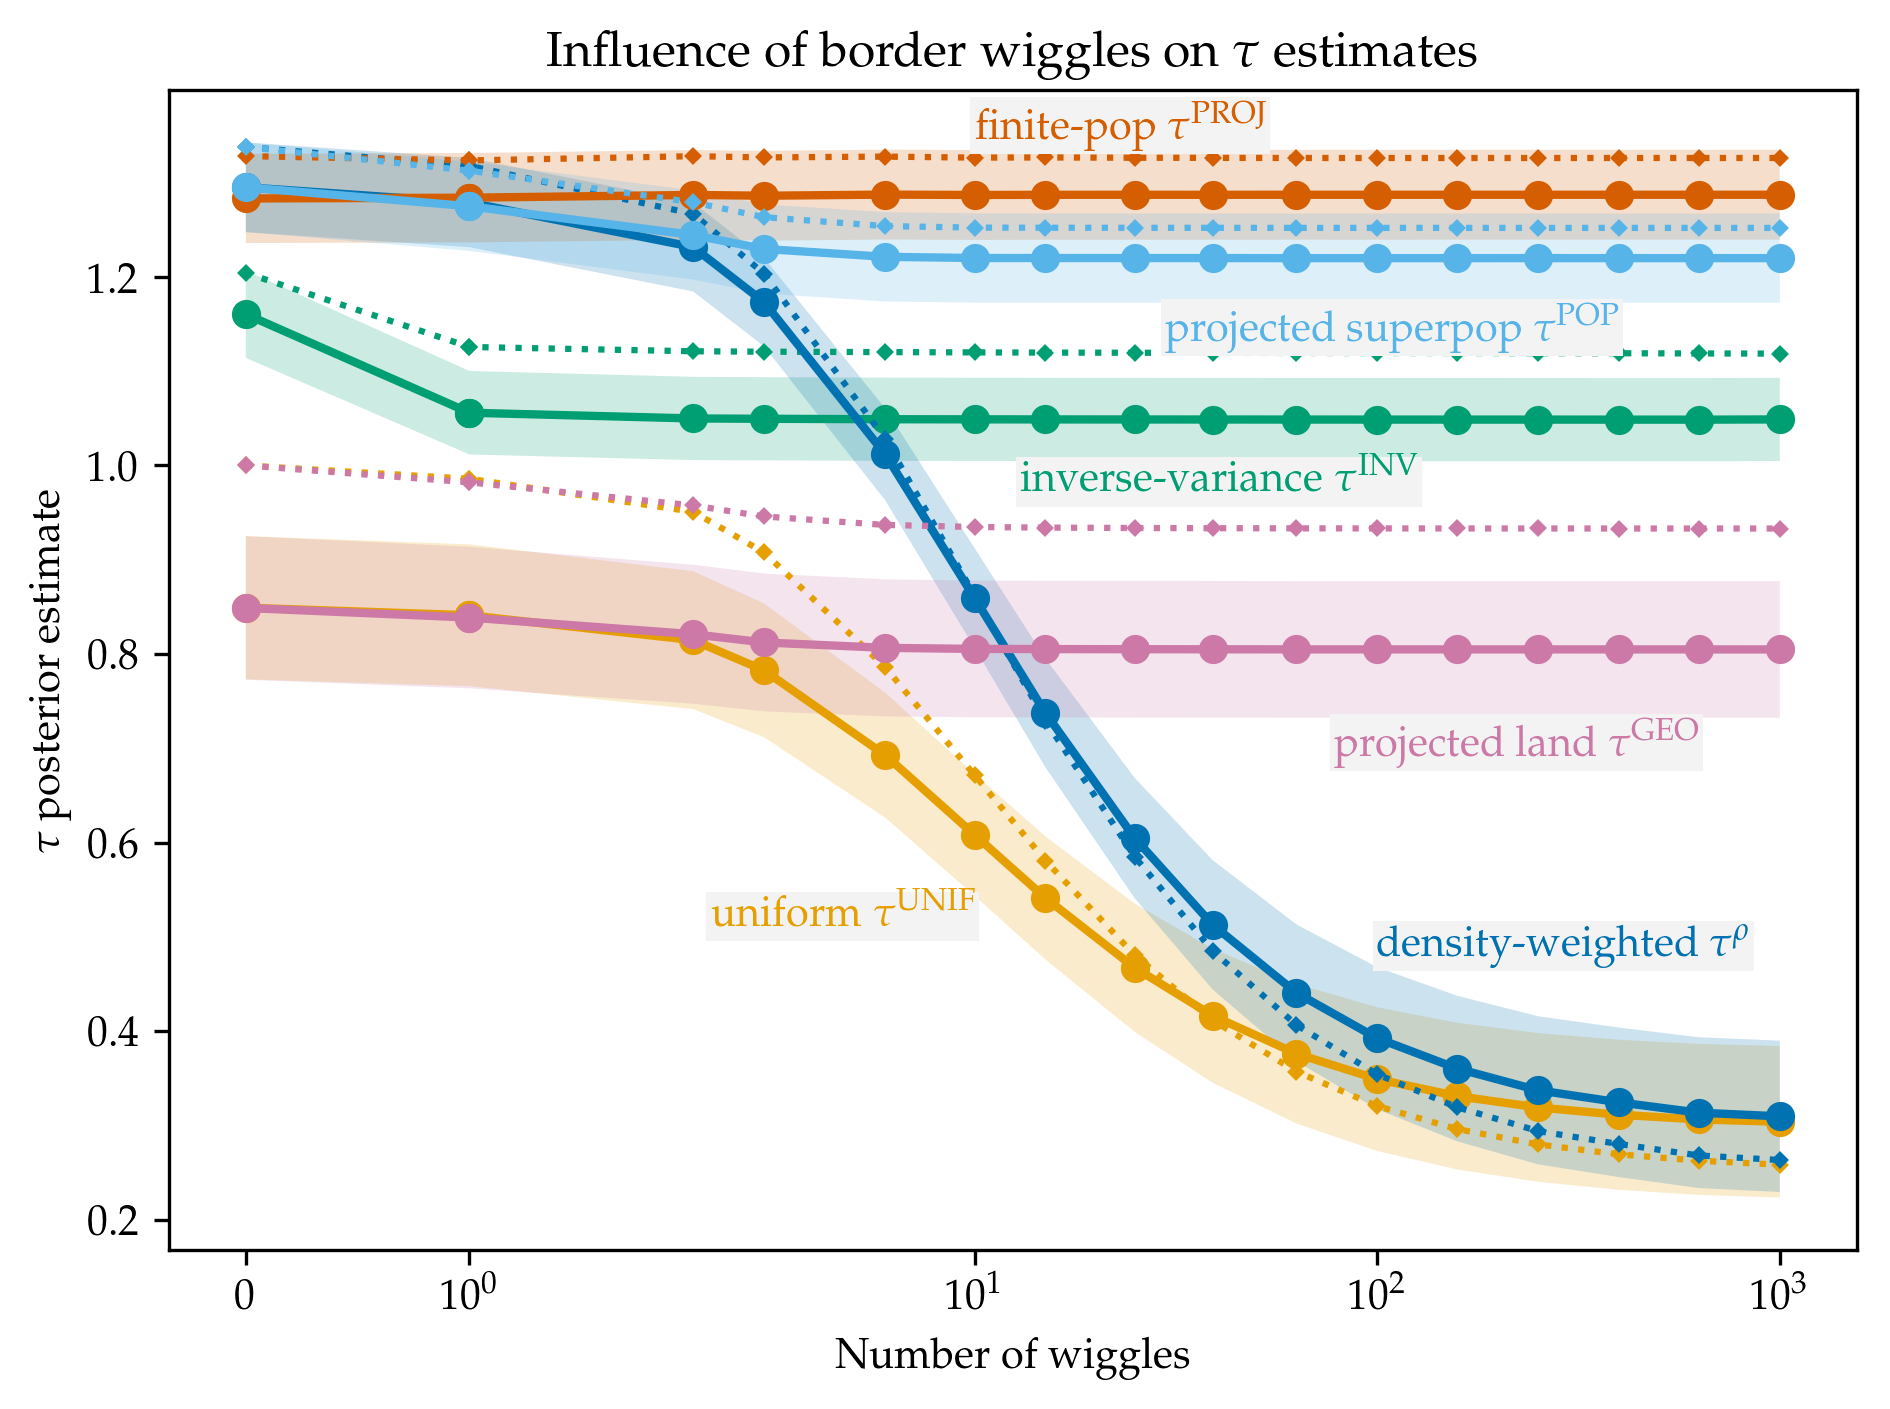

In [72]:
function plot_estimates()
    plt.title(L"Influence of border wiggles on $\tau$ estimates")
    capsize=3
    cbbPalette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", 
                  "#0072B2", "#D55E00", "#CC79A7"]
#     plt.axhline(wb_τrho_true, label=L"true $\tau^{\rho}$ w/o wiggles", 
#                 color=cbbPalette[4], linestyle="--")
#     plt.axhline(wb_τunif_true, label=L"true $\tau^{\mathrm{UNIF}}$ w/o wiggles", 
#                 color=cbbPalette[2], linestyle=":")
#     plt.axhline(τtrue[1], label=L"true $\tau:~S_1<0.5$", 
#                 color="grey", linestyle=":")
    for (iest, label, color, hatch, hatch_dens, label_x, label_above) in zip(
            1:6,
             [L"uniform $\tau^{\mathrm{UNIF}}$",
              L"inverse-variance $\tau^{\mathrm{INV}}$",
              L"density-weighted $\tau^{\rho}$",
              L"finite-pop $\tau^{\mathrm{PROJ}}$",
              L"projected land $\tau^{\mathrm{GEO}}$",
              L"projected superpop $\tau^{\mathrm{POP}}$",
              ],
             cbbPalette[[2,4,6,7,8,3]],
#              [ '/' | '\\' | '|' | '-' | '+' | 'x' | 'o' | 'O' | '.' | '*' ], 
             ["/", "|", "|", "\\", "\\", "/"],
             [7,6,5,7,6,5],
             [10^1,
              10^2.1,
              10^2.0,
              10^1.0,
              10^2.8,
              10^2.6],
             [:below,:below,:above,:above,:below,:below]
             )
        y = [mean(wbe[iest]) for wbe in wb_estimates]
        y_std = [std(wbe[iest]) for wbe in wb_estimates]
        plt.plot(wb_nwiggles_arr, 
            [mean(wbe[iest]) for wbe in estimands], 
            color=color,
            linestyle=":",
            marker="D",
            markersize=2,
            )
            
        plt.plot(wb_nwiggles_arr, y, 
                 color=color,
                 linewidth=2,
                 marker="o",
                 label=label,
                 )
                 
#         plt.fill_between(wb_nwiggles_arr, 
#             y1 = y .- y_std,
#             y2 = y .+ y_std,
#             facecolor="none",
#             edgecolor=color,
#             hatch=repeat(hatch, hatch_dens),
#             linewidth=0.0,
#             )
        plt.fill_between(wb_nwiggles_arr, 
            y1 = y .- y_std,
            y2 = y .+ y_std,
            facecolor = color,
            edgecolor = "none",
            linewidth = 0.0,
            alpha = 0.2,
            )

        y_label = y[end]
        if iest == 1
            y_label -= 0.2
        end
        
        if label_above==:above
            ilabel = searchsortedlast(wb_nwiggles_arr, label_x)
            verticalalignment="bottom"
            horizontalalignment="left"
            label_y = y[ilabel]+y_std[ilabel]
        else
            ilabel = searchsortedfirst(wb_nwiggles_arr, label_x)
            verticalalignment="top"
            horizontalalignment="right"
            label_y = y[ilabel]-y_std[ilabel]
        end
        plt.text(x=label_x, y=label_y, s=label,
                 color=color,
#                  rotation=45,
                 verticalalignment=verticalalignment,
                 horizontalalignment=horizontalalignment,
                 bbox=Dict("facecolor" => "#F3F3F3",
                           "edgecolor" => "none",
                           "pad" => 1.0,
                           )
                 )
    end
    plt.xlabel("Number of wiggles")
    plt.ylabel(L"$\tau$ posterior estimate")
    plt.gca()[:set_xscale]("symlog")
end
plt.plt[:interactive](false)
plot_estimates()
;

First a quick table to remind us of the simulation setup.

|                    | Left $x< 0.5$    | Middle $0.5 \ge x < 1.5$ | Right $1.5 \ge x$ |
|-------------------:|------------------|--------------------------|-------------------|
|         **Border** | wiggly           | straight                 | straight          |
|        **Density** | low $\rho=1.0$   | very low $\rho=0.1$      | high $\rho=2.8$   |
| $\mathbf{\tau(x)}$ | small            | medium                   | large             |

In the plot, we see the effect very clearly: when there is only one wiggle, the inverse-variance and density-weighted estimates are in pretty close agreement, close to the true value of $\tau$. The unweighted estimator gives more weight to the left (less dense) region, which also has lower $\tau(x)$, leading to a lower $\hat\tau$ estimate. But as more wiggles get added, and hence more grid points are added to the left (wiggly) region, the unweighted and density-weighted estimates systematically give more weight to the left region, and hence the estimates go down. Meanwhile, the inverse-variance estimator, because it takes the covariance structure into account, is not susceptible to this issue.

Obviously, the extremely wiggly border is unrealistic in most situations, but this does highlight an undesirable feature of the density-weighted estimator. Another manifestation of this issue is that the estimate changes if the gridpoints aren't evenly spaced.

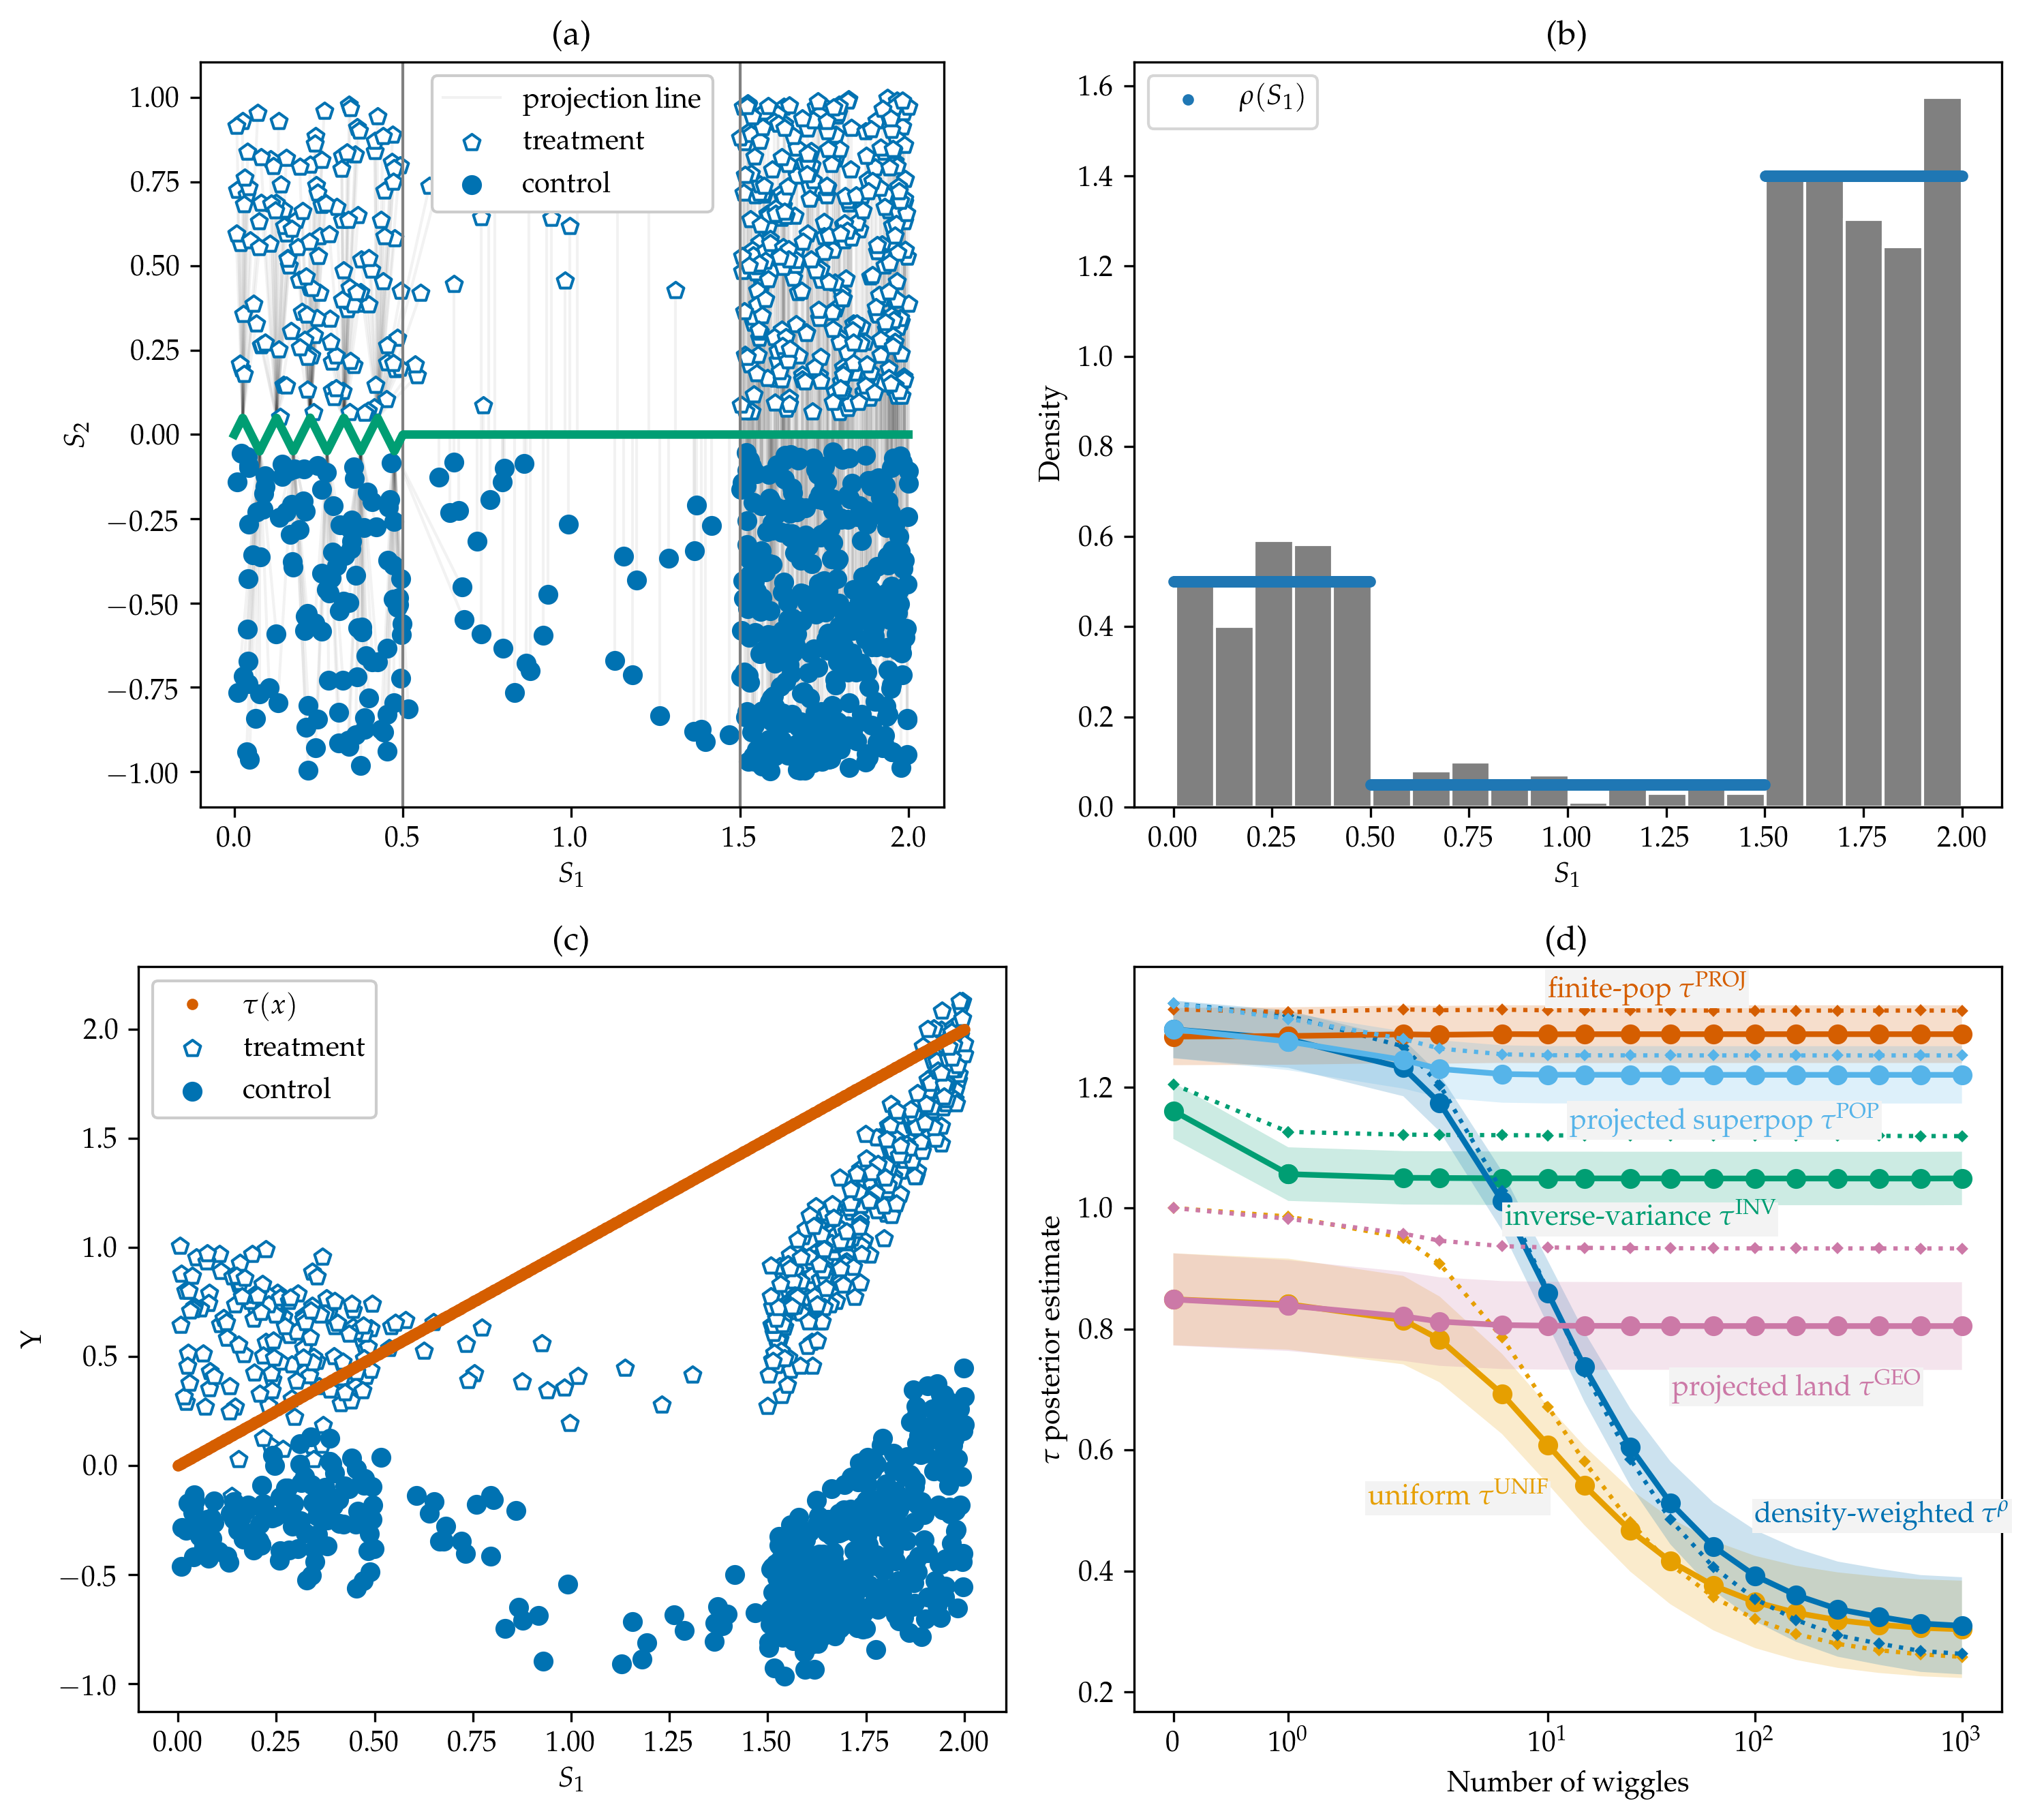

In [73]:
fig=plt.figure()
fig[:set_size_inches](10.0,9.0)
plt.subplot(2,2,1)
plot_setup()
plt.title("(a)")
plt.subplot(2,2,2)
plot_x1()
plt.title("(b)")
plt.subplot(2,2,3)
plot_outcomes()
plt.title("(c)")
plt.subplot(2,2,4)
plot_estimates()
plt.title("(d)")
plt.savefig("figures/wiggly_boundaries.png")
plt.savefig("figures/wiggly_boundaries.pdf")
;

# Inverse-variance: what's going on?

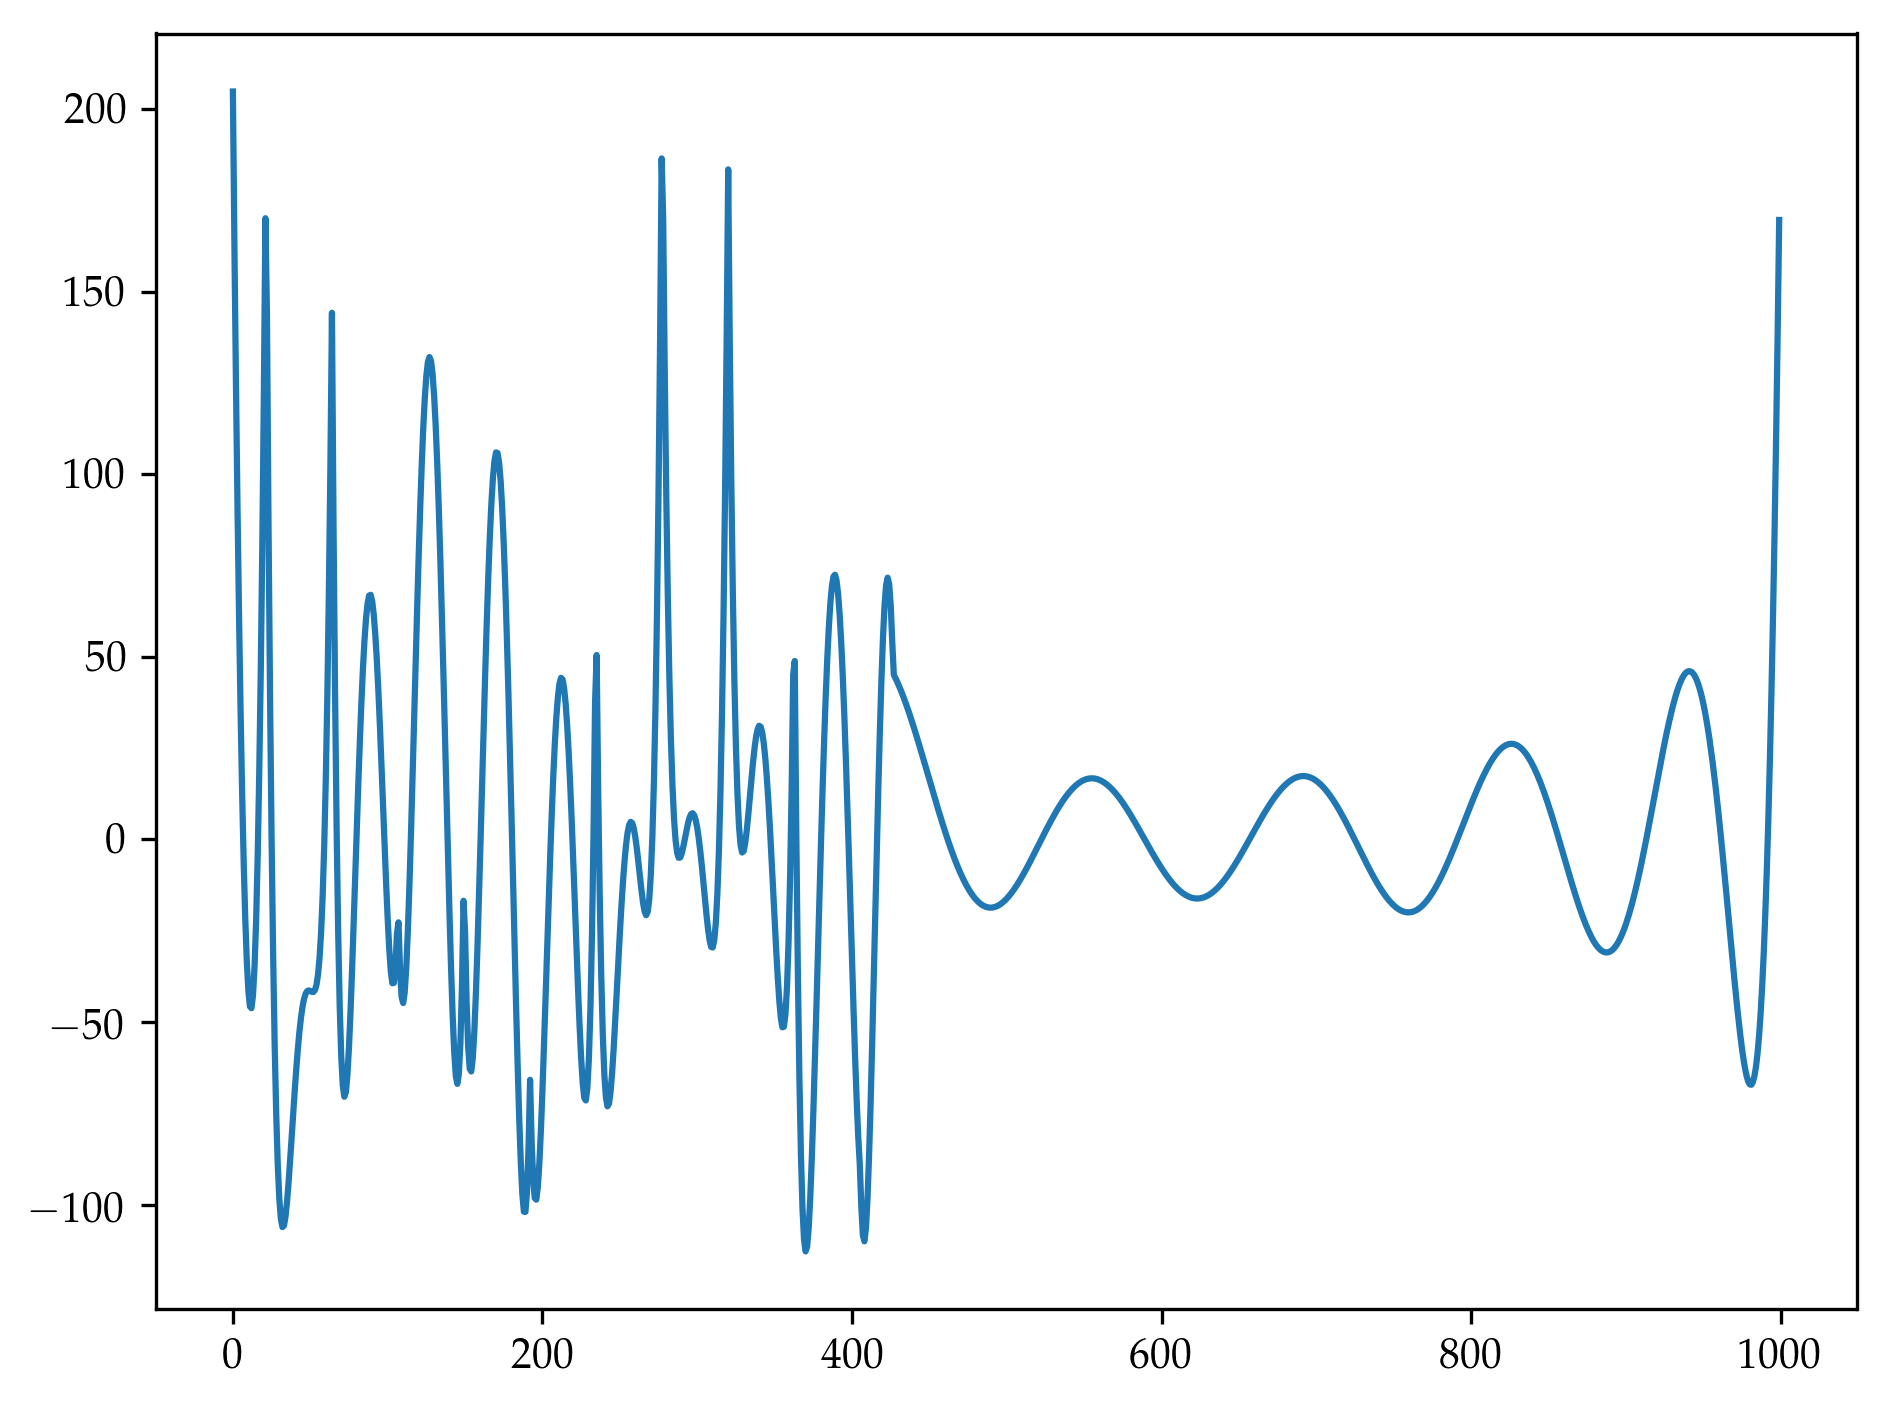

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x15685f278>

In [46]:
nwiggles = 5
border = border_line(nwiggles, wb_A)
n∂ = 1000
X∂ = sentinels(border, n∂)
μpost, Σpost = GeoRDD.cliff_face(wb_fit_treat, wb_fit_ctrol, X∂)
plt.plot(Σpost \ ones(n∂))

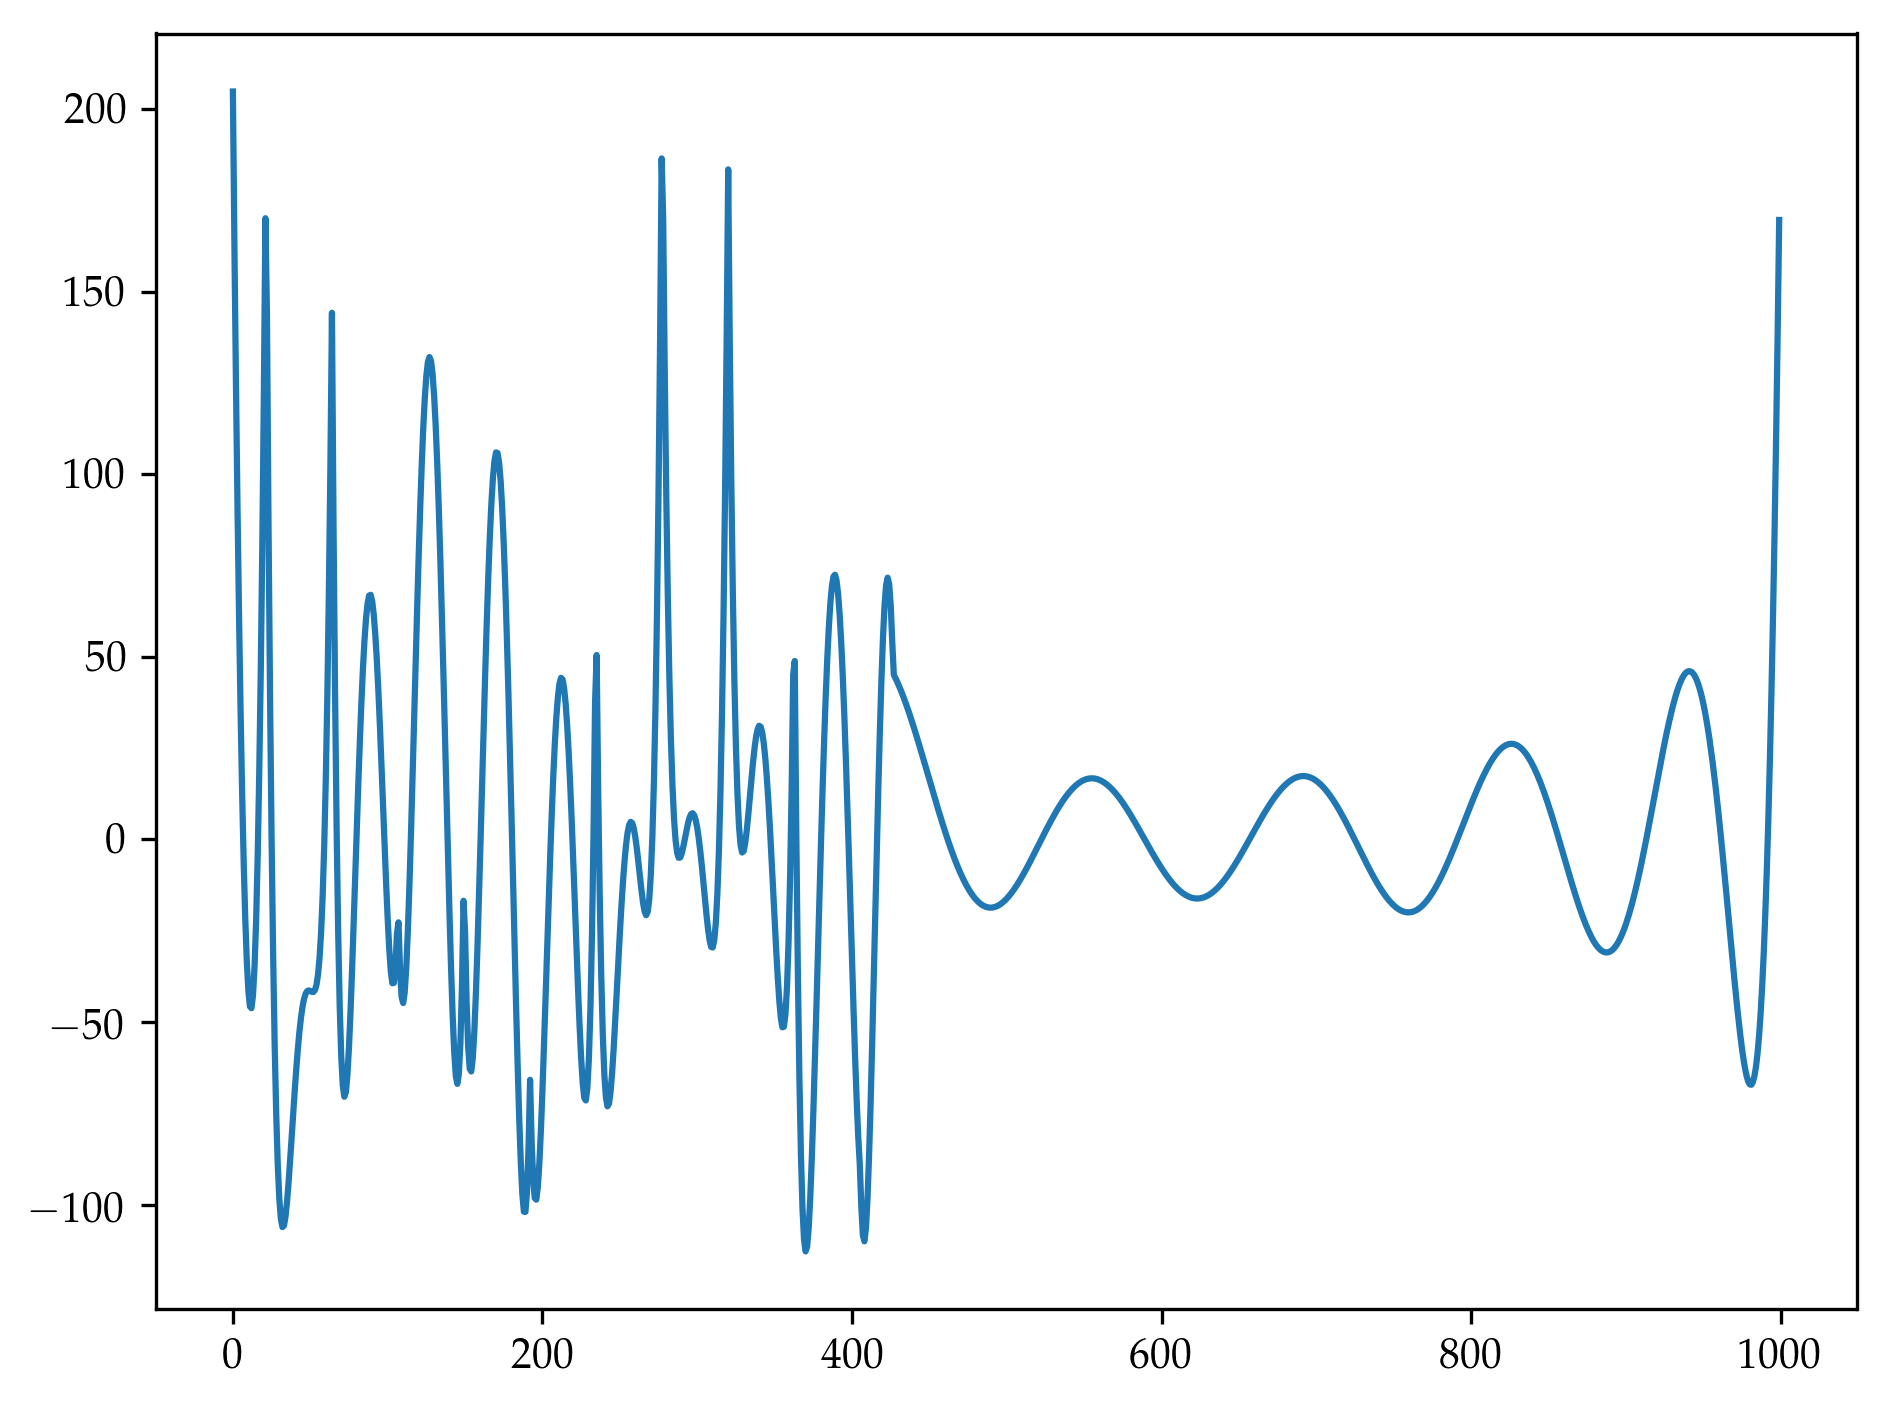

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14fbfc4e0>

In [47]:
nwiggles = 5
border = border_line(nwiggles, wb_A)
n∂ = 1000
X∂ = sentinels(border, n∂)
μpost, Σpost = GeoRDD.cliff_face(wb_fit_treat, wb_fit_ctrol, X∂)
plt.plot(Σpost \ ones(n∂))

# Table

In [74]:
import DataFrames
import DataTables
wiggly_df = DataTables.DataTable()
wiggly_df[:nwiggles] = wb_nwiggles_arr
for (iest, label) in enumerate([
        :unifavg,
        :invvar,
        :taurho,
        :tauproj,
        :taugeo,
        :taupop])
    y = [mean(wbe[iest]) for wbe in wb_estimates]
    y_err = [std(wbe[iest]) for wbe in wb_estimates]
    y_estimand = [mean(wbe[iest]) for wbe in estimands]
    
    str_y_se = [@sprintf("%.2f (%.2f)", x, xerr) 
                for (x,xerr) in zip(y, y_err)]
    str_y_estimand = [@sprintf("%.2f", x) for x in y_estimand]
    
    wiggly_df[Symbol("hat ", label)] = str_y_se
    wiggly_df[label] = str_y_estimand
end
DataTables.head(wiggly_df)
print(reprmime("text/latex", wiggly_df))

\begin{tabular}{r|ccccccccccccc}
	& nwiggles & hat unifavg & unifavg & hat invvar & invvar & hat taurho & taurho & hat tauproj & tauproj & hat taugeo & taugeo & hat taupop & taupop\\
	\hline
	1 & 0 & 0.85 (0.08) & 1.00 & 1.16 (0.05) & 1.20 & 1.30 (0.05) & 1.34 & 1.28 (0.05) & 1.33 & 0.85 (0.08) & 1.00 & 1.30 (0.05) & 1.34 \\
	2 & 1 & 0.84 (0.08) & 0.99 & 1.06 (0.04) & 1.13 & 1.28 (0.05) & 1.32 & 1.28 (0.05) & 1.32 & 0.84 (0.08) & 0.98 & 1.27 (0.05) & 1.31 \\
	3 & 1 & 0.84 (0.08) & 0.99 & 1.06 (0.04) & 1.13 & 1.28 (0.05) & 1.32 & 1.28 (0.05) & 1.32 & 0.84 (0.08) & 0.98 & 1.27 (0.05) & 1.31 \\
	4 & 2 & 0.81 (0.07) & 0.95 & 1.05 (0.04) & 1.12 & 1.23 (0.05) & 1.27 & 1.29 (0.05) & 1.33 & 0.82 (0.07) & 0.96 & 1.24 (0.05) & 1.28 \\
	5 & 3 & 0.78 (0.07) & 0.91 & 1.05 (0.04) & 1.12 & 1.17 (0.05) & 1.20 & 1.29 (0.05) & 1.33 & 0.81 (0.07) & 0.95 & 1.23 (0.05) & 1.26 \\
	6 & 6 & 0.69 (0.07) & 0.79 & 1.05 (0.04) & 1.12 & 1.01 (0.05) & 1.03 & 1.29 (0.05) & 1.33 & 0.81 (0.07) & 0.94 & 1.22 (0.05) & 1